# Лабораторная работа №2

In [58]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
!pip install -q catalyst

In [49]:
pip install --upgrade catalyst

Defaulting to user installation because normal site-packages is not writeable
  Using cached catalyst-22.4-py2.py3-none-any.whl.metadata (58 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Requested catalyst from https://files.pythonhosted.org/packages/05/09/36a4acd1c3112f2e2da74f4340778100a205ecb59166be00dc6287f3364f/catalyst-22.4-py2.py3-none-any.whl has invalid metadata: Expected matching RIGHT_PARENTHESIS for LEFT_PARENTHESIS, after version specifier
    scikit-image (<0.19.0>=0.16.1) ; extra == 'all'
                 ~~~~~~~~^


In [57]:
pip install typing-extensions

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import sys
import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

#from catalyst import utils

import collections
if sys.version_info.major == 3 and sys.version_info.minor >= 10:

    from collections.abc import MutableMapping
else:
    from collections import MutableMapping

sns.set(style="darkgrid", font_scale=1.4)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn)
        self.bias = bias
        if bias:
            self.bias_term = # YOUR CODE GOES HERE

    def forward(self, x):
        x =  # YOUR CODE GOES HERE
        if self.bias:
            x +=  # YOUR CODE GOES HERE
        return x

SyntaxError: invalid syntax (<ipython-input-3-4a9fc74657a5>, line 7)

In [16]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features)) 
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))  # YOUR CODE GOES HERE

    def forward(self, x):
        x = torch.matmul(x, self.weights)  # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term  # YOUR CODE GOES HERE
        return x

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [17]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

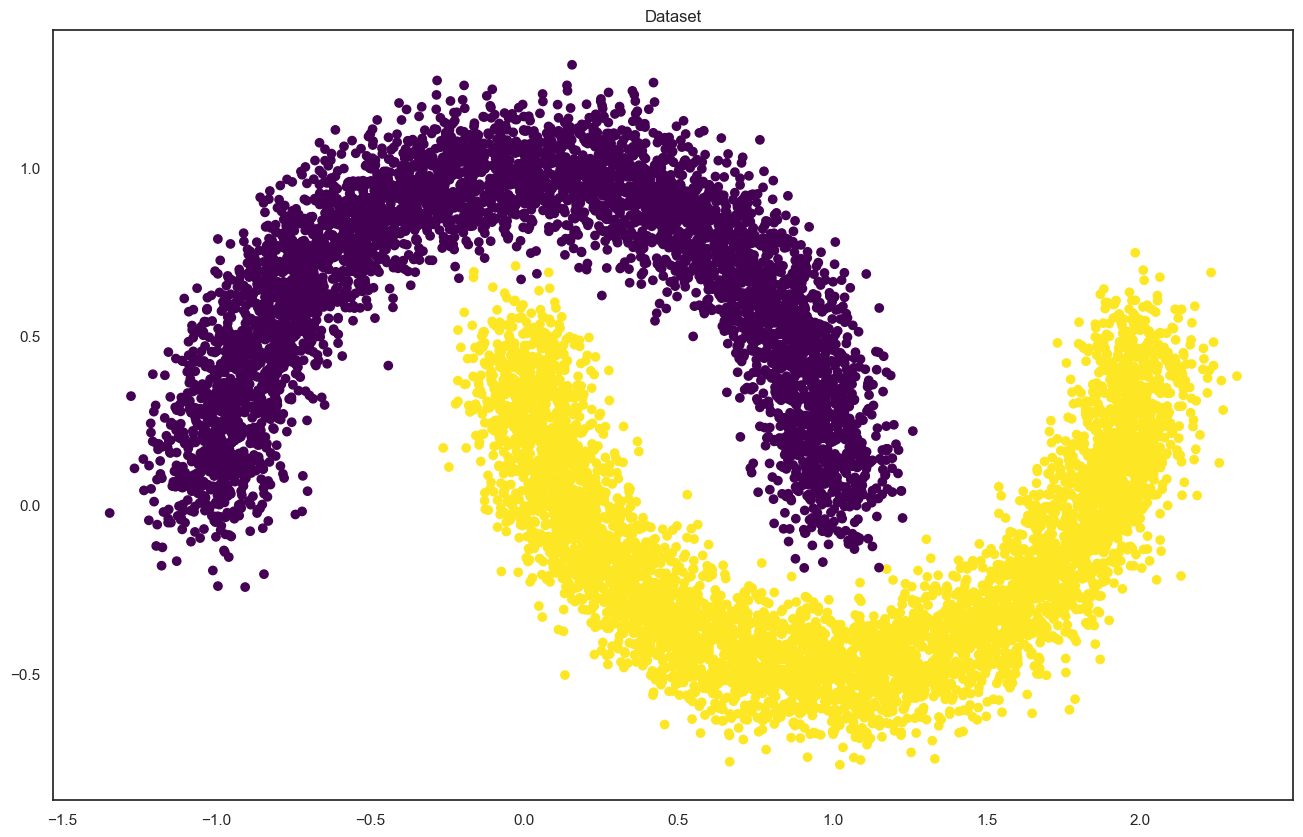

In [18]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [20]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)  # YOUR CODE GOES HERE
y_train_t = torch.tensor(y_train, dtype=torch.float32)  # YOUR CODE GOES HERE
X_val_t = torch.tensor(X_val, dtype=torch.float32)      # YOUR CODE GOES HERE
y_val_t = torch.tensor(y_val, dtype=torch.float32)      # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`.

In [21]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [22]:
#utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [23]:
pytorch_total_params = sum(p.numel() for p in linear_regression.parameters() if p.requires_grad) # количество обучаемых параметров у модели
pytorch_total_params

3

In [24]:
len({e.data_ptr() for p in linear_regression.parameters() if p.requires_grad for e in p.view(-1)}) #ещё один способ найти кол-во обучаемых параметров у модели

3

**Вопрос 1** Сколько обучаемых параметров у получившейся модели?

**Ответ:** 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    utils.set_global_seed(42 + epoch)
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  # YOUR CODE GOES HERE
        loss =  # YOUR CODE GOES HERE
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  # YOUR CODE GOES HERE
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.234375
Iteration: 7500
Batch accuracy: 0.4140625
Iteration: 15000
Batch accuracy: 0.5
Iteration: 22500
Batch accuracy: 0.6796875
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.890625
Iteration: 45000
Batch accuracy: 0.875
Iteration: 52500
Batch accuracy: 0.875
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8359375
Iteration: 75000
Batch accuracy: 0.890625
Iteration: 82500
Batch accuracy: 0.9296875
Iteration: 90000
Batch accuracy: 0.90625
Iteration: 97500
Batch accuracy: 0.875
Iteration: 105000
Batch accuracy: 0.8515625
Iteration: 112500
Batch accuracy: 0.859375
Iteration: 120000
Batch accuracy: 0.875
Iteration: 127500
Batch accuracy: 0.8828125
Iteration: 135000
Batch accuracy: 0.8515625
Iteration: 142500
Batch accuracy: 0.8515625
Iteration: 150000
Batch accuracy: 0.828125
Iteration: 157500
Batch accuracy: 0.8828125
Iteration: 165000
Batch accuracy: 0.859375
Iteration: 172500
Batch accuracy: 0.9

In [25]:
tol = 1e-3 #сравниваем тестовые с тренеровочными
losses = []
max_epochs = 100 # кол-во эпох
prev_weights = torch.zeros_like(linear_regression.weights) # обнуляем предыдущие веса
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad() # обнуление градиента
        outp =  linear_regression(X_batch).flatten()
        #print("X_batch")
        #print(X_batch)
        #print("y_batch")
        #print(y_batch)
        #break
    #break
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  loss # YOUR CODE GOES HERE
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        if (it + epoch * len(train_dataloader)) % 10 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}. Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 10
Batch accuracy: 0.40625
Iteration: 20
Batch accuracy: 0.4765625
Iteration: 30
Batch accuracy: 0.5703125
Iteration: 40
Batch accuracy: 0.453125
Iteration: 50
Batch accuracy: 0.5546875
Iteration: 60
Batch accuracy: 0.59375
Iteration: 70
Batch accuracy: 0.515625
Iteration: 80
Batch accuracy: 0.5078125
Iteration: 90
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.453125
Iteration: 110
Batch accuracy: 0.484375
Iteration: 120
Batch accuracy: 0.5703125
Iteration: 130
Batch accuracy: 0.546875
Iteration: 140
Batch accuracy: 0.5234375
Iteration: 150
Batch accuracy: 0.484375
Iteration: 160
Batch accuracy: 0.5625
Iteration: 170
Batch accuracy: 0.4609375
Iteration: 180
Batch accuracy: 0.46875
Iteration: 190
Batch accuracy: 0.515625
Iteration: 200
Batch accuracy: 0.5390625
Iteration: 210
Batch accuracy: 0.46875
Iteration: 220
Batch accuracy: 0.46875
Iteration: 230
Batch accuracy: 0.5078125
Iteration: 240
Batch accuracy: 0.484375
Iteration

**Вопрос 2**

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 873

### Визуализируем результаты

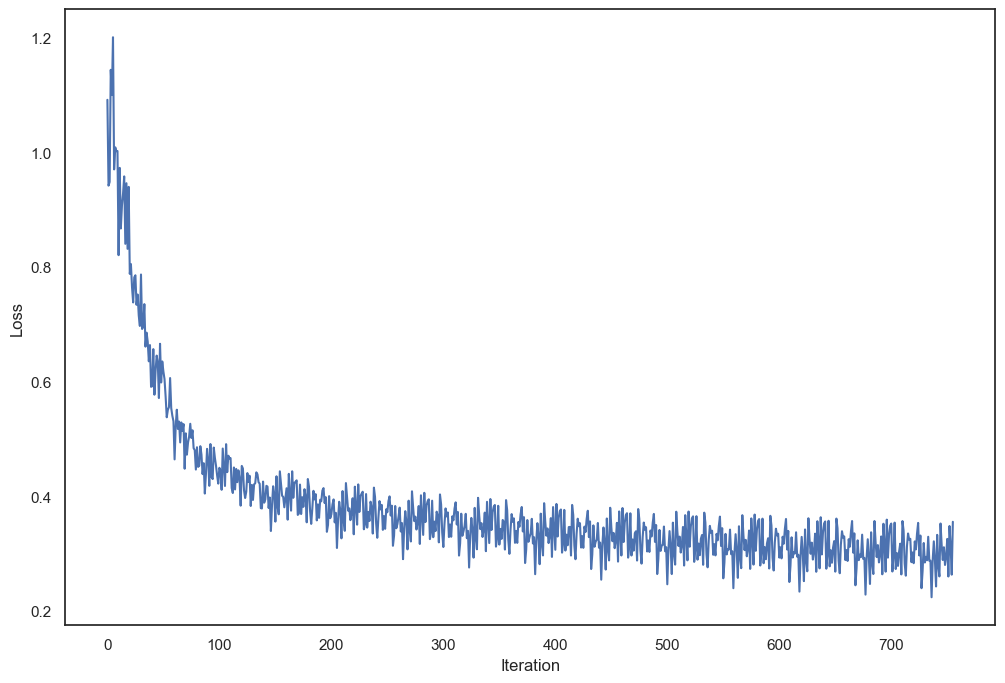

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

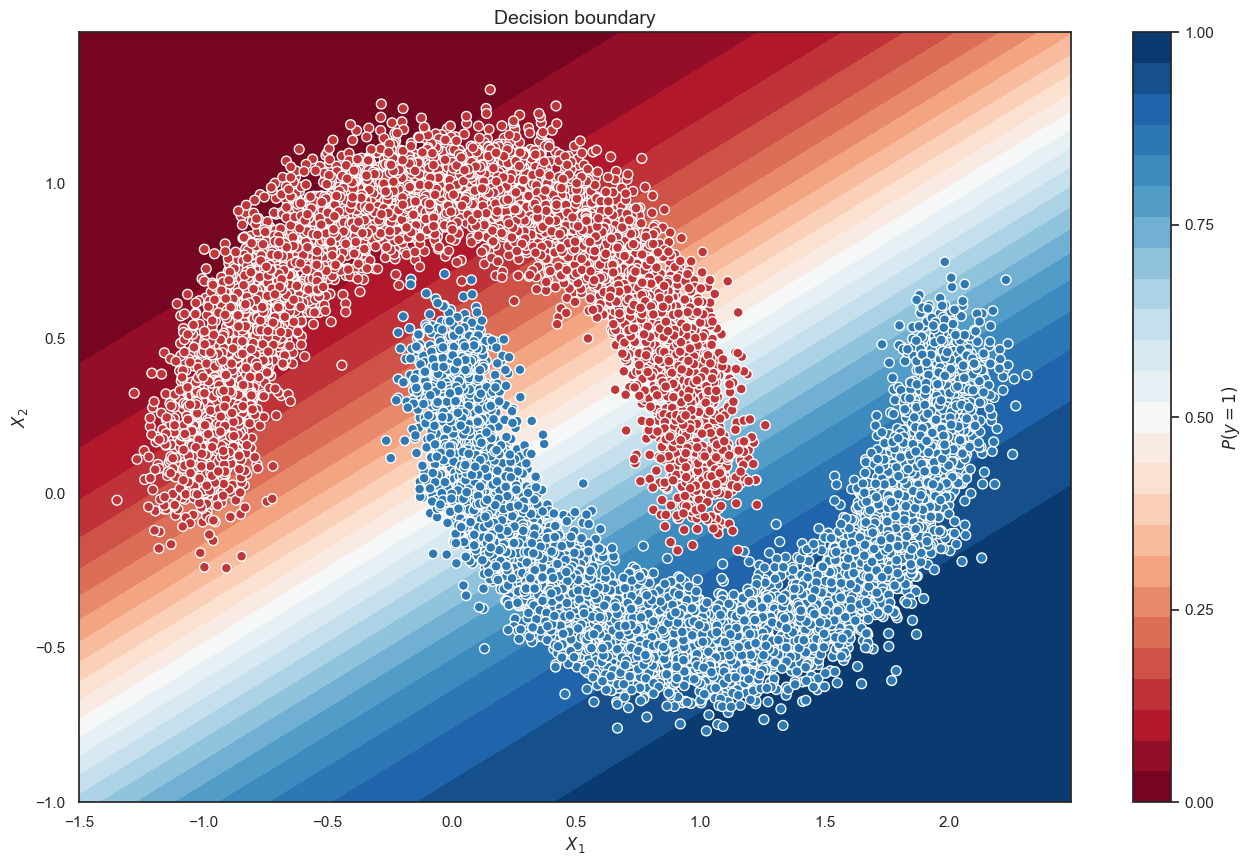

In [27]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [28]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [29]:
from sklearn.metrics import accuracy_score

y_pred_t = predict(val_dataloader, linear_regression)
y_pred_t = np.where(y_pred_t > 0.5, 1, 0) # выбор элементов в зависимости от условия
accuracy_score(y_val_t, y_pred_t) # сравнение предсказанных значений с действительными
# YOUR CODE GOES HERE

0.8608

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8584

### MNIST

In [30]:
import os
from catalyst.contrib.datasets import MNIST

train_dataset = MNIST(root=os.getcwd(), train=True, download=True)
val_dataset = MNIST(root=os.getcwd(), train=False)
train_dataloader =  # YOUR CODE GOES HERE
valid_dataloader =  # YOUR CODE GOES HERE

SyntaxError: invalid syntax (2140571961.py, line 6)

In [32]:
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch

class MNISTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32).unsqueeze(1) / 255.0  # Нормализация
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Загрузка данных с OpenML
mnist = fetch_openml('mnist_784', version=1)
data = mnist.data.values
labels = mnist.target.astype(np.int64).to_numpy()  # Преобразование в numpy

# Разделение на обучающий и проверочный наборы
train_data, val_data = data[:60000], data[60000:]
train_labels, val_labels = labels[:60000], labels[60000:]

# Создание датасетов
train_dataset = MNISTDataset(train_data.reshape(-1, 28, 28), train_labels)
val_dataset = MNISTDataset(val_data.reshape(-1, 28, 28), val_labels)

# Создание DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [33]:
class Identical(nn.Module):
    def forward(self, x):
        return x

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

In [50]:
activation = nn.Sigmoid

model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [37]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    epoch_correct = 0
    epoch_all = 0
    utils.set_global_seed(42 + epoch)
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct =  # YOUR CODE GOES HERE
            all =  # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


IndentationError: expected an indented block after 'if' statement on line 9 (4132560658.py, line 11)

In [53]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":  #обозначаем модель
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                    # Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum() # корректные значения, у совпали
            all =  preds.size(0) # всего значений
            epoch_correct += correct.item() # эпоха - период существования нейроной сети
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.7840666666666667
Loader: valid. Accuracy: 0.9112
Epoch: 2
Loader: train. Accuracy: 0.9248833333333333
Loader: valid. Accuracy: 0.9376
Epoch: 3
Loader: train. Accuracy: 0.9444333333333333
Loader: valid. Accuracy: 0.951
Epoch: 4
Loader: train. Accuracy: 0.9559833333333333
Loader: valid. Accuracy: 0.9574
Epoch: 5
Loader: train. Accuracy: 0.9639833333333333
Loader: valid. Accuracy: 0.9624
Epoch: 6
Loader: train. Accuracy: 0.9700833333333333
Loader: valid. Accuracy: 0.9663
Epoch: 7
Loader: train. Accuracy: 0.9748833333333333
Loader: valid. Accuracy: 0.9706
Epoch: 8
Loader: train. Accuracy: 0.9782166666666666
Loader: valid. Accuracy: 0.9727
Epoch: 9
Loader: train. Accuracy: 0.9817833333333333
Loader: valid. Accuracy: 0.9729
Epoch: 10
Loader: train. Accuracy: 0.9844666666666667
Loader: valid. Accuracy: 0.9744


Попробуйте разные функции активации. Позапускайте ячейки сверху несколько раз изменив функции активации. После каждого обучения запустите одну из ячеек снизу. Таким образом мы получим график accuracy/epoch для каждой функции активации.

In [39]:
plain_accuracy = accuracy["valid"]

In [44]:
relu_accuracy = accuracy["valid"]

In [49]:
leaky_relu_accuracy = accuracy["valid"]

In [54]:
elu_accuracy = accuracy["valid"]

### Accuracy

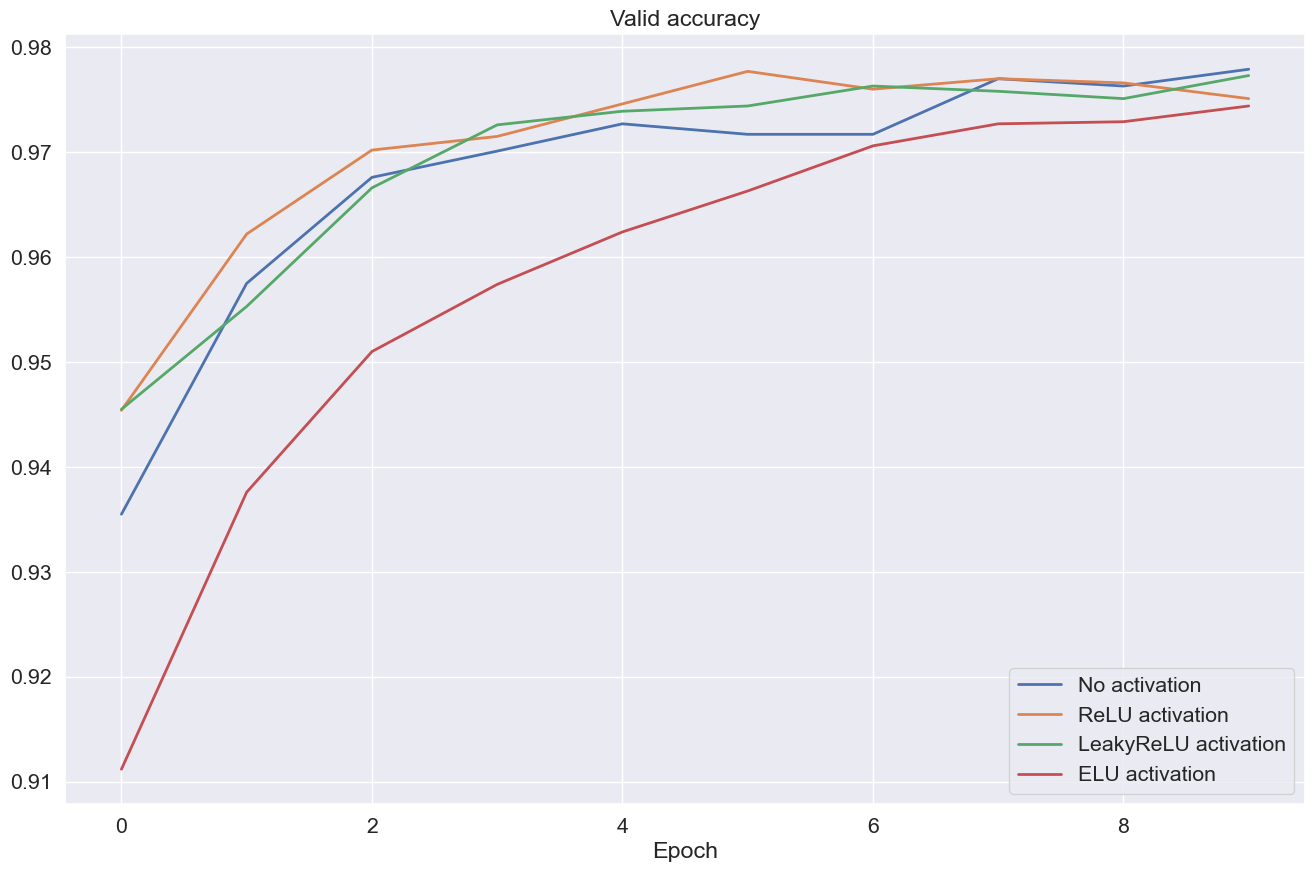

In [55]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

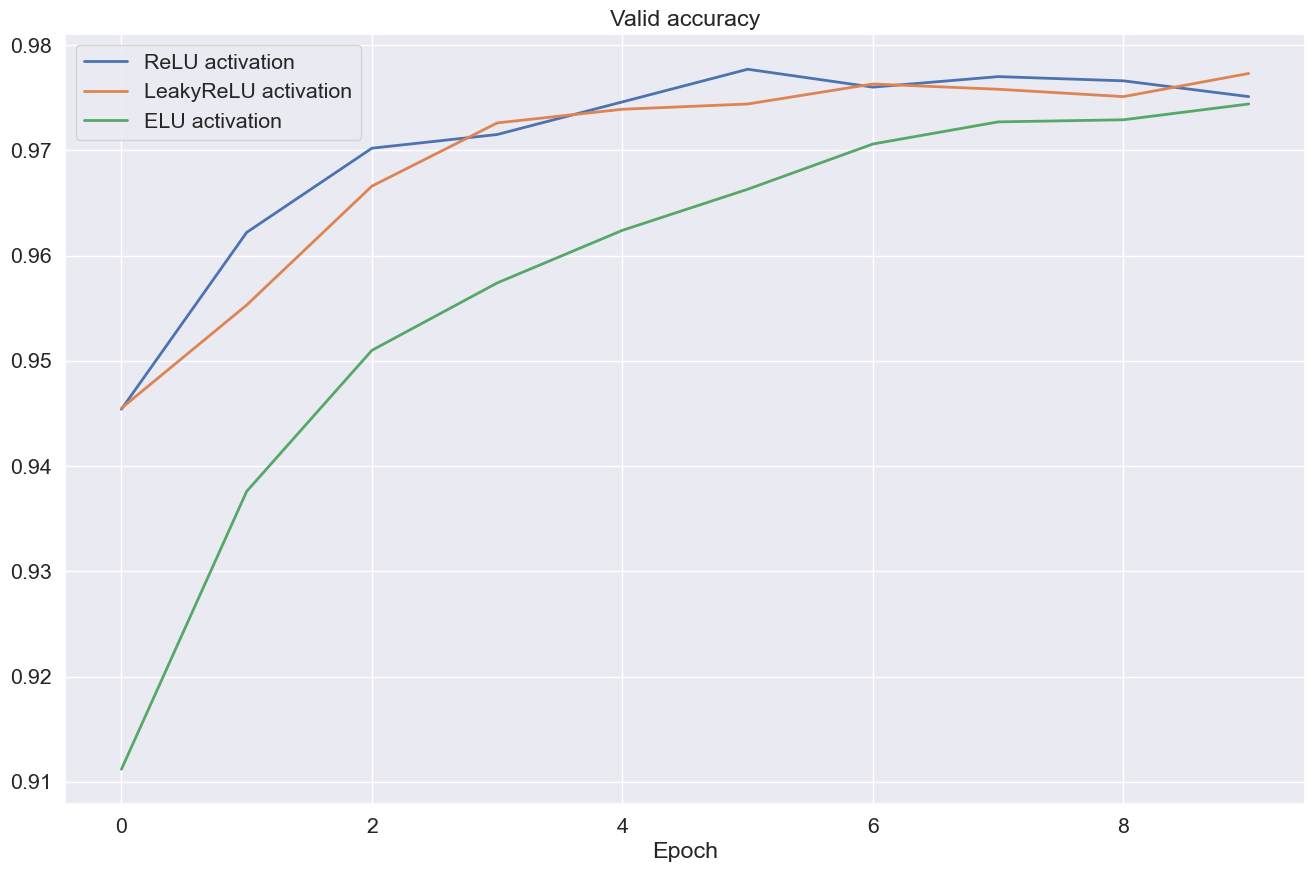

In [56]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4** Какая из активаций показала наивысший `accuracy`?

**Ответ:** LeakyReLU

## Сверточные слои

### Ядра

In [7]:
# необходимо импортировать свою картинку
# это можно сделать либо с помощью !wget, либо через интерфейс colab'а слева
# в разделе "Files"
!wget https://storage-api.petstory.ru/resize/1000x1000x80/cb/48/7f/cb487f4677a640329e92ac0076004607.jpeg -O photo.jpeg

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


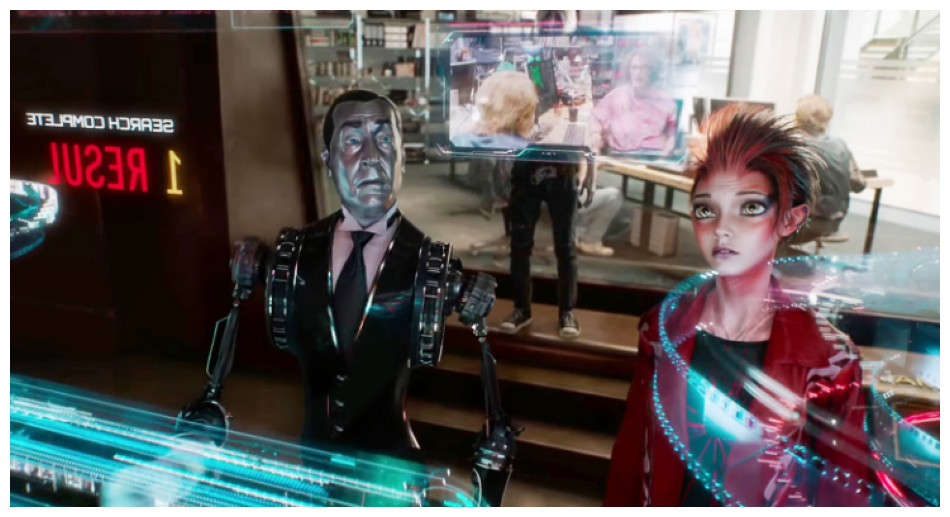

In [57]:
# Загрузить изображение
img = cv2.imread("Photo.jpeg") 
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sns.set(style="white")
# Отобразить изображение
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.axis("off")
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [58]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

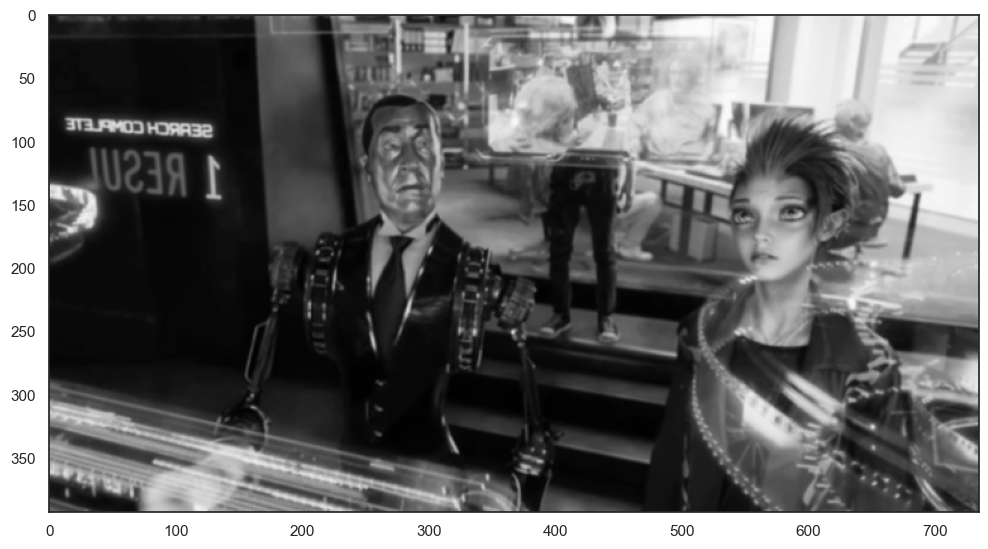

In [59]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5** Как вы считаете, как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** Е, Д, А, В, Б, Г

### LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Давайте посмотрим на архитектуру, предложенную еще в 1998 году!

In [60]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Определение устройства (GPU если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [62]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for X_batch, y_batch in dataloader:

            if k == "train":
                 # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(X_batch.to(device))
            else:
                 # Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(X_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()
            all = preds.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.86775
Loader: valid. Accuracy: 0.9643
Epoch: 2
Loader: train. Accuracy: 0.9639833333333333
Loader: valid. Accuracy: 0.9681
Epoch: 3
Loader: train. Accuracy: 0.9723666666666667
Loader: valid. Accuracy: 0.9756
Epoch: 4
Loader: train. Accuracy: 0.9788833333333333
Loader: valid. Accuracy: 0.9828
Epoch: 5
Loader: train. Accuracy: 0.9822666666666666
Loader: valid. Accuracy: 0.9821
Epoch: 6
Loader: train. Accuracy: 0.9841833333333333
Loader: valid. Accuracy: 0.982
Epoch: 7
Loader: train. Accuracy: 0.9866166666666667
Loader: valid. Accuracy: 0.9835
Epoch: 8
Loader: train. Accuracy: 0.9877166666666667
Loader: valid. Accuracy: 0.9858
Epoch: 9
Loader: train. Accuracy: 0.9889
Loader: valid. Accuracy: 0.9856
Epoch: 10
Loader: train. Accuracy: 0.99035
Loader: valid. Accuracy: 0.9881


In [63]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

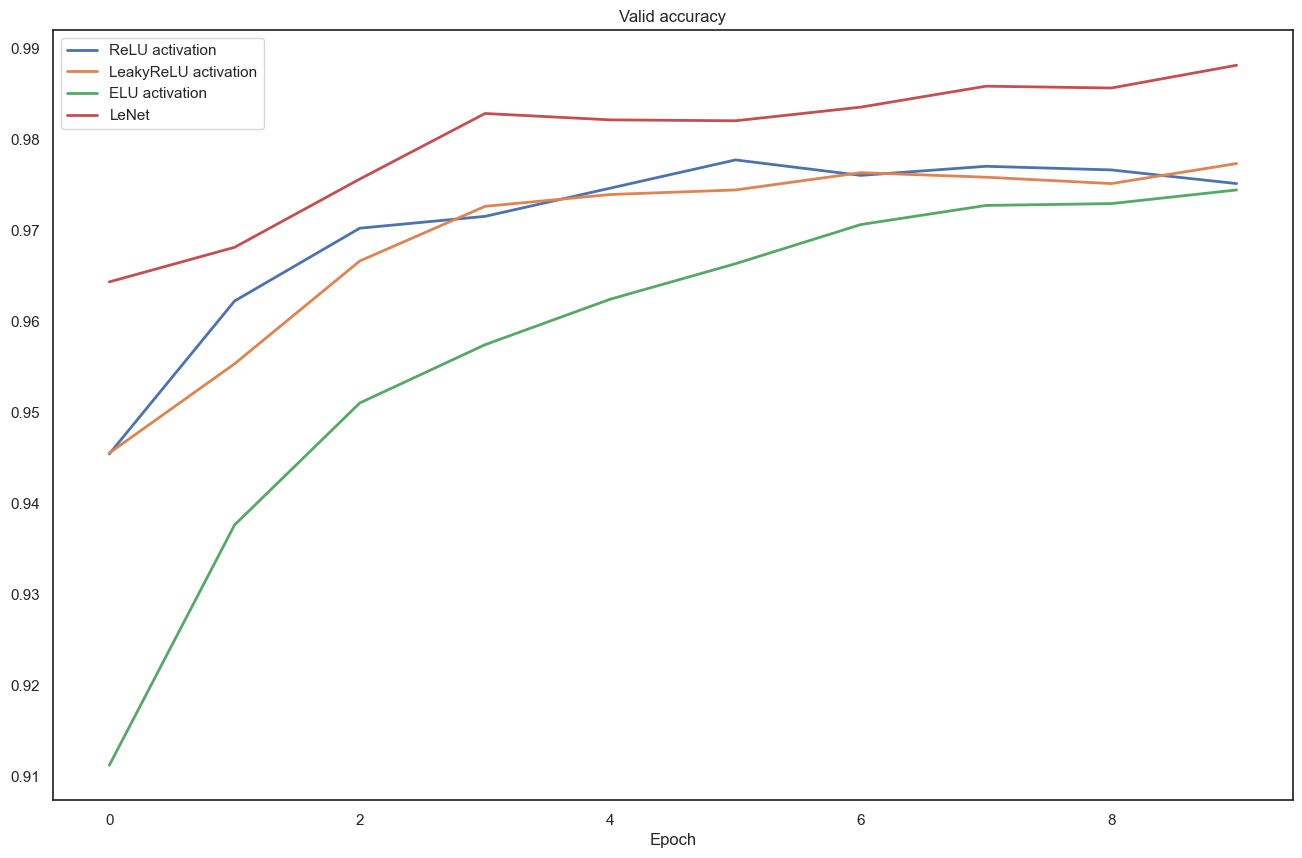

In [64]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0,99